In [1]:
import sys
sys.path.append('../')
from fine_classif.feat_extract.lc_utils import *
from fine_classif.feat_extract.lc_utils import fourier_poly_chi2_fit_transpose as single_comp

from astropy.timeseries.periodograms.lombscargle.implementations.utils import bitceil, factorial
from fine_classif.feat_extract.nfft_utils import complex_exponential_sum
import time

In [369]:
def extirpolate(x, y, N=None, M=4):
    """
    Extirpolate the values (x, y) onto an integer grid range(N),
    using lagrange polynomial weights on the M nearest points.
    Parameters
    ----------
    x : array_like
        array of abscissas
    y : array_like
        array of ordinates
    N : int
        number of integer bins to use. For best performance, N should be larger
        than the maximum of x
    M : int
        number of adjoining points on which to extirpolate.

    Returns
    -------
    yN : ndarray
         N extirpolated values associated with range(N)

    Example
    -------
    >>> rng = np.random.RandomState(0)
    >>> x = 100 * rng.rand(20)
    >>> y = np.sin(x)
    >>> y_hat = extirpolate(x, y)
    >>> x_hat = np.arange(len(y_hat))
    >>> f = lambda x: np.sin(x / 10)
    >>> np.allclose(np.sum(y * f(x)), np.sum(y_hat * f(x_hat)))
    True

    Notes
    -----
    This code is based on the C implementation of spread() presented in
    Numerical Recipes in C, Second Edition (Press et al. 1989; p.583).
    """
#     x, y = map(np.ravel, np.broadcast_arrays(x, y))

    if N is None:
        N = int(np.max(x) + 0.5 * M + 1)

    # Now use legendre polynomial weights to populate the results array;
    # This is an efficient recursive implementation (See Press et al. 1989)

    result = np.zeros((N, *np.shape(y)[1:]), dtype=y.dtype)

    # first take care of the easy cases where x is an integer
    integers = (x % 1 == 0)
    np.add.at(result, x[integers].astype(int), y[integers])
    x, y = x[~integers], y[~integers]

    # For each remaining x, find the index describing the extirpolation range.
    # i.e. ilo[i] < x[i] < ilo[i] + M with x[i] in the center,
    # adjusted so that the limits are within the range 0...N
    ilo = np.clip((x - M // 2).astype(int), 0, N - M)
    numerator = y * np.prod(x - ilo - np.arange(M)[:, np.newaxis], 0)[:, np.newaxis]
    denominator = factorial(M - 1)

    for j in range(M):
        if j > 0:
            denominator *= j / (j - M)
        ind = ilo + (M - 1 - j)
        np.add.at(result, ind, numerator / (denominator * (x - ind))[:, np.newaxis])
    return result


def trig_sum(t, h, df, N, f0=0, freq_factor=1,
             oversampling=5, use_fft=True, Mfft=4):
    """Compute (approximate) trigonometric sums for a number of frequencies
    This routine computes weighted sine and cosine sums:
        S_j = sum_i { h_i * sin(2 pi * f_j * t_i) }
        C_j = sum_i { h_i * cos(2 pi * f_j * t_i) }
    Where f_j = freq_factor * (f0 + j * df) for the values j in 1 ... N.
    The sums can be computed either by a brute force O[N^2] method, or
    by an FFT-based O[Nlog(N)] method.

    Parameters
    ----------
    t : array_like
        array of input times
    h : array_like
        array weights for the sum
    df : float
        frequency spacing
    N : int
        number of frequency bins to return
    f0 : float (optional, default=0)
        The low frequency to use
    freq_factor : float (optional, default=1)
        Factor which multiplies the frequency
    use_fft : bool
        if True, use the approximate FFT algorithm to compute the result.
        This uses the FFT with Press & Rybicki's Lagrangian extirpolation.
    oversampling : int (default = 5)
        oversampling freq_factor for the approximation; roughly the number of
        time samples across the highest-frequency sinusoid. This parameter
        contains the trade-off between accuracy and speed. Not referenced
        if use_fft is False.
    Mfft : int
        The number of adjacent points to use in the FFT approximation.
        Not referenced if use_fft is False.

    Returns
    -------
    S, C : ndarrays
        summation arrays for frequencies f = df * np.arange(1, N + 1)
    """
    df *= freq_factor
    f0 *= freq_factor

    if df <= 0:
        raise ValueError("df must be positive")
        
    if use_fft:
        Mfft = int(Mfft)
        if Mfft <= 0:
            raise ValueError("Mfft must be positive")

        # required size of fft is the power of 2 above the oversampling rate
        Nfft = bitceil(N * oversampling)
        t0 = t.min()

        if f0 > 0:
            h = h * np.exp(2j * np.pi * f0 * (t - t0))[:, np.newaxis]

        tnorm = ((t - t0) * Nfft * df) % Nfft
        grid = extirpolate(tnorm, h, Nfft, Mfft)
        
        fftgrid = np.fft.ifft(grid, axis=0)[:N]
        
        if t0 != 0:
            f = f0 + df * np.arange(N)
            fftgrid *= np.exp(2j * np.pi * t0 * f[:, np.newaxis])

        C = Nfft * fftgrid.real
        S = Nfft * fftgrid.imag
    else:
        f = f0 + df * np.arange(N)
        C = np.dot(h.T, np.cos(2 * np.pi * f * t[:, np.newaxis])).T
        S = np.dot(h.T, np.sin(2 * np.pi * f * t[:, np.newaxis])).T

    return S, C



def trig_sum_nfft(t, y, freq_factor, use_nfft, **kwargs):
    if kwargs['df'] * freq_factor * (t.max() - t.min()) > 1 or not use_nfft:
        S, C = trig_sum(t, y, freq_factor=freq_factor, **kwargs)
        return C + S * 1j
    else:
        return complex_exponential_sum(t * freq_factor, y, kwargs['f0'],
                                       kwargs['N'], kwargs['df'])
    
def trig_sum_nfft_freq_factor(t, h, freq_factor_max, df, N, Mfft=4, oversampling=5, f0=0., use_fft=True):
    
    if f0>0:
        print('f0 must be 0')
    
    Nm = freq_factor_max * N
    
    Mfft = int(Mfft)
    if Mfft <= 0:
        raise ValueError("Mfft must be positive")

    # required size of fft is the power of 2 above the oversampling rate
    Nfft = bitceil(Nm * oversampling)
    t0 = t.min()

    if f0 > 0:
        h = h * np.exp(2j * np.pi * f0 * (t - t0))[:, np.newaxis]

    tnorm = ((t - t0) * Nfft * df) % Nfft
    grid = extirpolate(tnorm, h, Nfft, Mfft)

    fftgrid = np.fft.ifft(grid, axis=0)[:Nm]

    if t0 != 0:
        f = f0 + df * np.arange(Nm)
        fftgrid *= np.exp(2j * np.pi * t0 * f[:, np.newaxis])

    fftgrid *= Nfft
    
    return np.array([fftgrid[::f][:N] for f in range(1, freq_factor_max+1)])
    

In [453]:
def fourier_poly_chi2_fit_transpose(times,
                          mag,
                          inverr2,
                          f0,
                          f1,
                          Nf,
                          nterms=1,
                          normalization='standard',
                          npoly=1,
                          use_nfft=True,
                          regularization=0.,
                          regularization_power=2.,
                          time_zeropoint_poly=2457000.,
                          regularize_by_trace=True):
    """
        Faster implementation of astropy fastchi2 lombscargle.
        Faster because the linalg.solve is vectorized
        
        Parameters
        ----------
        times, mag, err : array_like
            time, values and errors for datapoints
        f0, f1, Nf : (float, float, int)
            parameters describing the frequency grid, f = np.linspace(f0,f1,Nf)
        nterms : int
            number of Fourier terms to use (default 1)
        npoly: int
            number of polynomial terms to use (default 1)
        use_nfft: bool
            if True, use NFFT library. This puts limitations on frequency grid so 
            defaults to no NFFT if conditions not satisfied.
        normalization: string
            how to normalize power (see astropy.timeseries.LombScargle)
        regularization: float (default = 0.)
            regularization term sum_i (y-Mx)^2/sigma^2 + regularization n M^T M
        regularization_power: float (default = 2.)
            power of k to raise regularization term to
        time_zeropoint_poly: float (default = 2457000.)
            time shift to apply when evaluting polynomial terms
        regularize_by_trace: bool (default = True)
            regularization = regularization * sum(inverr^2) -- Vanderplas & Ivezic (2015)
    """

    df = (f1 - f0) / (Nf - 1)
    if df <= 0:
        raise ValueError("df must be positive")

#     inverr2 = 1. / err**2
    ws = np.sum(inverr2, axis=0)
    meanmag = np.einsum('ij,ij->j', inverr2, mag) / ws
    mag = mag - meanmag[np.newaxis, :]
    magw = inverr2 * mag
    magws = np.sum(magw, axis=0)

    # Scale regularization to number of datapoints
    if regularize_by_trace:
        regularization *= np.sum(inverr2)
    else:
        regularization *= len(inverr2)

    Nsources = np.shape(mag)[1]
    tm = time.time()
    Q = np.empty((1 + 2 * nterms, Nf, Nsources), dtype=np.complex)
    Q[0] = ws
    P = np.empty((1 + nterms, Nf, Nsources), dtype=np.complex)
    P[0] = magws
    if npoly>1:
        QT = np.empty((npoly - 1, nterms, Nf, Nsources), dtype=np.complex)

    kwargs = dict(f0=f0, df=df, use_fft=True, N=Nf, oversampling=3)
    
    Q[1:] = np.array([
        trig_sum_nfft(times, inverr2, k, use_nfft, **kwargs)
        for k in range(1, 2 * nterms + 1)
    ])
    
    P[1:] = np.array([
        trig_sum_nfft(times, magw, k, use_nfft, **kwargs)
        for k in range(1, nterms + 1)
    ])
    
    if npoly>1:
        QT = np.array([[
            trig_sum_nfft(times,
                          inverr2 * np.power(times - time_zeropoint_poly, p), k,
                          use_nfft, **kwargs) for p in range(1, npoly) 
        ] for k in range(1, nterms + 1)])
        
        Pl = np.array([
            np.sum(np.power(times - time_zeropoint_poly, k) * magw, axis=0)
            for k in range(1, npoly)
        ])
        
        Ql = np.array([
            np.sum(np.power(times - time_zeropoint_poly, k) * inverr2, axis=0)
            for k in range(1, 2 * npoly - 1)
        ])
    
    tm = time.time()
    beta = np.empty((2 * nterms + npoly, Nf, Nsources))
    alpha = np.empty((2 * nterms + npoly, 2 * nterms + npoly, Nf, Nsources))
#     beta = np.empty((Nf, Nsources, 2 * nterms + npoly))
#     alpha = np.empty((Nf, Nsources, 2 * nterms + npoly, 2 * nterms + npoly))
    
    p = np.empty((Nsources, Nf))
    soln = np.empty((Nsources, Nf, 2 * nterms + npoly))

    beta[:1 + 2 * nterms:2] = np.real(P)
    beta[1:1 + 2 * nterms:2] = np.imag(P[1:])
    if npoly>1:
        beta[1 + 2 * nterms:] = Pl[:, np.newaxis, np.newaxis]
    print('1',(time.time()-tm)*1000);tm = time.time()

    # Looks odd but when negative indices they are always zero
#     for n in range(nterms + 1):
#         for m in range(nterms + 1):
#     N, M = [f.flatten() for f in np.meshgrid(np.arange(nterms + 1), np.arange(nterms + 1))]

#     M = np.arange(nterms+1)
#     tm = time.time()
#     for n in np.arange(nterms+1):
#         alpha[2 * n - 1, ::2] = np.real(.5 * (Q[abs(M - n)] - Q[M + n]))
#     print('2.1',(time.time()-tm)*1000);tm = time.time()
#     alpha[2 * N, 2 * M] = np.real(.5 * (Q[abs(M - N)] + Q[M + N]))
#     alpha[2 * N, 2 * M - 1] = np.imag(.5 * (np.sign(M - N)[:,np.newaxis,np.newaxis] * Q[np.abs(M - N)] + Q[M + N]))
#     alpha[2 * N - 1, 2 * M] = np.imag(.5 * (np.sign(N - M)[:,np.newaxis,np.newaxis] * Q[np.abs(M - N)] + Q[M + N]))
    
    for m,n in product(np.arange(nterms + 1), np.arange(nterms + 1)):
        alpha[2 * n - 1, 2 * m - 1] = np.real(.5 * (Q[np.abs(m-n)] - Q[m+n]))
#         print('2.1',(time.time()-tm)*1000);tm = time.time()
        alpha[2 * n - 1, 2 * m] = np.imag(.5 * (np.sign(n - m) * Q[np.abs(m-n)] + Q[m+n]))
#         print('2.2',(time.time()-tm)*1000);tm = time.time()
        alpha[2 * n, 2 * m - 1] = np.imag(.5 * (np.sign(m - n) * Q[np.abs(m-n)] + Q[m+n]))
#         print('2.3',(time.time()-tm)*1000);tm = time.time()
        alpha[2 * n, 2 * m] = np.real(.5 * (Q[np.abs(m-n)] + Q[m+n]))
#         print('2.4',(time.time()-tm)*1000);tm = time.time()
        
    print('2',(time.time()-tm)*1000);tm = time.time()
    
    if npoly>1:
        for n in range(1, npoly):
            for m in range(1, npoly):
                alpha[2 * nterms + n, 2 * nterms + m] = Ql[m + n - 1]
        for n in range(1, nterms + 1):
            for m in range(1, npoly):
                alpha[2 * n - 1, 2 * nterms + m] = np.imag(QT[n - 1, m - 1])
                alpha[2 * n, 2 * nterms + m] = np.real(QT[n - 1, m - 1])
                alpha[2 * nterms + m, 2 * n - 1] = np.imag(QT[n - 1, m - 1])
                alpha[2 * nterms + m, 2 * n] = np.real(QT[n - 1, m - 1])
        for m in range(1, npoly):
            alpha[0, 2 * nterms + m] = Ql[m - 1]
            alpha[2 * nterms + m, 0] = Ql[m - 1]
    print('3',(time.time()-tm)*1000);tm = time.time()

    # Regularization term
    if regularization:
        for m in range(1, nterms + 1):
            alpha[2 * m - 1, 2 * m - 1] \
                += regularization * np.power(m, regularization_power)
            alpha[2 * m, 2 * m] \
                += regularization * np.power(m, regularization_power)

    ## To avoid singular matrices
    alpha += (np.identity(2 * nterms + npoly) * np.min(np.abs(alpha)) *
              1e-4)[:, :, np.newaxis, np.newaxis]
    print('4',(time.time()-tm)*1000);tm = time.time()
    
    tm = time.time()
    alpha = alpha.T
    beta = beta.T
    print('5',(time.time()-tm)*1000);tm = time.time()
    
    soln = np.linalg.solve(alpha, beta)
    print('5',(time.time()-tm)*1000)
    
    tm = time.time()
    p = np.sum(beta * soln, axis=-1)
    p[p < 0.] = 0.
    soln[:, :, 0] += meanmag[:, np.newaxis]
    chi2_ref = np.sum(mag * mag * inverr2, axis=0)[:,np.newaxis]

    if normalization == 'psd':
        p *= 0.5
    elif normalization == 'standard':
        p /= chi2_ref
    elif normalization == 'log':
        p = -np.log(1 - p / chi2_ref)
    elif normalization == 'model':
        p /= chi2_ref - p
    elif normalization == 'chi2':
        p = chi2_ref - p
    else:
        raise ValueError("normalization='{}' "
                         "not recognized".format(normalization))


    results = {}
    freq_grid = np.linspace(f0, f1, Nf)
#     results['fourier_coeffs_grid'] = soln
#     results['inv_covariance_matrix'] = alpha
    results['power'] = p
    results['freq_grid'] = freq_grid
#     results['chi2_ref'] = np.sum(mag * mag * inverr2, axis=0)
    
    loc = np.argmax(p, axis=1)
    results['fourier_coeffs'] = soln[np.arange(Nsources), loc]
    results['period'] = 1./freq_grid[loc]
    results['chi2_ref'] = np.sum(mag * mag * inverr2, axis=0)
    print((time.time()-tm)*1000)

    return results

In [454]:
%%timeit -n 1 -r 1
fourier_poly_chi2_fit_transpose(mjdobs, mags[:,:100], inverr2[:,:100], 1./5000., 100., 2**14, 4, use_nfft=False)

1 49.698591232299805
2 1453.620433807373
3 0.000476837158203125
4 565.5629634857178
5 0.0040531158447265625
5 2200.2501487731934
104.94780540466309
7.47 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [354]:
%%timeit -n 1 -r 1
ft_s=\
    [single_comp(mjdobs[inverr2[:,ii]>0.], mags[:,ii][inverr2[:,ii]>0.], 
                 1./np.sqrt(inverr2[:,ii])[inverr2[:,ii]>0.],1./5000., 100., 2**18, 4, use_nfft=True)
     for ii in range(10)]

23.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [350]:
single_comp

262144

In [346]:
len(autofrequency(mjdobs, minimum_frequency=1./5000., maximum_frequency=25., samples_per_peak=3))

236338

In [312]:
%%timeit -n 1 -r 1
[fourier_poly_chi2_fit_transpose(mjdobs[inverr2[:,ii]>0.], mags[:,ii:ii+1][inverr2[:,ii]>0.], inverr2[:,ii:ii+1][inverr2[:,ii]>0.], 1./5000., 100., 2**16, 4, use_nfft=False)
 for ii in range(10)]

[]
1 1.2323856353759766
2 35.81643104553223
3 0.0054836273193359375
4 21.991968154907227
5 83.60576629638672
3.3638477325439453
[]
1 1.2340545654296875
2 34.795522689819336
3 0.0050067901611328125
4 21.890640258789062
5 83.3737850189209
3.4034252166748047
[]
1 1.1835098266601562
2 34.75642204284668
3 0.0054836273193359375
4 21.94046974182129
5 83.47654342651367
3.329753875732422
[]
1 1.201629638671875
2 35.53199768066406
3 0.0050067901611328125
4 21.905899047851562
5 83.12225341796875
3.3655166625976562
[]
1 1.1734962463378906
2 36.4072322845459
3 0.005245208740234375
4 21.886825561523438
5 83.07003974914551
3.365039825439453
[]
1 1.234292984008789
2 35.24279594421387
3 0.0054836273193359375
4 22.02606201171875
5 81.31647109985352
3.517627716064453
[]
1 1.2326240539550781
2 41.27979278564453
3 0.0050067901611328125
4 22.204160690307617
5 81.75110816955566
3.4973621368408203
[]
1 1.2421607971191406
2 36.23485565185547
3 0.005245208740234375
4 22.000789642333984
5 81.14981651306152
3.560

In [295]:
ft = fourier_poly_chi2_fit_transpose(mjdobs, mags[:,:10], inverr2[:,:10], 1e-10, 100., 2**16, 4, use_nfft=False)

0.1 4.870414733886719
f0 must be 0
0.2 2218.061685562134
f0 must be 0
0.3 1029.6494960784912
0.4 0.03981590270996094
[]
0.5 0.06890296936035156
0.6 0.003337860107421875
1 20.426511764526367
2 481.7979335784912
3 0.006198883056640625
4 226.77326202392578
5 901.5281200408936
42.44637489318848


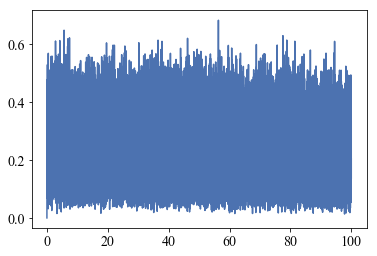

In [296]:
plt.plot(ft['freq_grid'], ft['power'][1]);
# plt.semilogy()
# plt.semilogx()

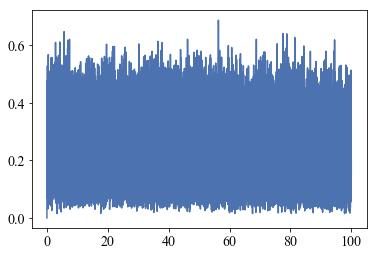

In [293]:
plt.plot(ft['freq_grid'], ft['power'][1]);
# plt.semilogy()
# plt.semilogx()

In [38]:
kwargs = dict(f0=0.1, df=0.01, use_fft=True, N=1000)

In [191]:
# %%timeit -n 5 -r 1
freq_factor = 5
Nf=10
ss=trig_sum_nfft(mjdobs, inverr2[:,:1], 1, False, f0=0., df=0.01, use_fft=True, N=Nf*freq_factor)

0.05364418029785156


In [221]:
%%timeit -n 5 -r 1
ss_x=trig_sum_nfft_freq_factor(mjdobs, inverr2[:,:100], freq_factor, df=0.01, Nf=Nf)

33.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)


In [225]:
ss_x=trig_sum_nfft_freq_factor(mjdobs, inverr2[:,:100], freq_factor, df=0.01, Nf=Nf)

In [228]:
np.shape(ss_x)

(5, 10, 100)

In [206]:
%%timeit -n 5 -r 1
ss_x2=\
[trig_sum_nfft(mjdobs, inverr2[:,:100], ff, False, f0=0., df=0.01, use_fft=True, N=Nf)
 for ff in range(1, freq_factor+1)]

113 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)


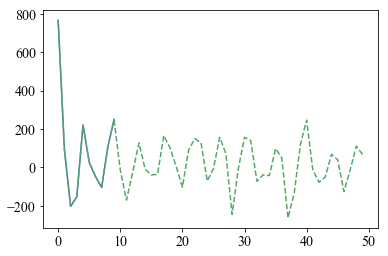

In [202]:
plt.plot(ss_x2[0])
plt.plot(ss_x[0],ls='dashed');
# plt.plot(ss[::freq_factor]);

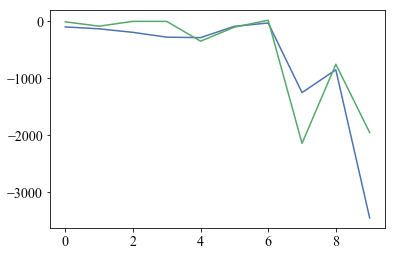

In [55]:
plt.plot(ss_2[0])
plt.plot(ss[0])

In [86]:
np.max(mjdobs)-np.min(mjdobs)

3151.1845588399956

In [87]:
1./100.

0.01

In [239]:
%%timeit -n 1 -r 1
fourier_poly_chi2_fit_transpose(mjdobs, mags[:,:1], inverr2[:,:1], 1./5000., 100., 2**18, 4, use_nfft=False)

0.1 1.3875961303710938
0.2 1365.2901649475098
0.3 588.5992050170898
0.4 0.024080276489257812
0.5 0.0035762786865234375
0.6 0.0035762786865234375
1 4.932403564453125
2 202.86917686462402
3 0.0040531158447265625
4 89.41769599914551
5 445.71995735168457
13.945579528808594
2.71 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [96]:
%%timeit -n 1 -r 1
fourier_poly_chi2_fit_transpose(mjdobs, mags[:,:100], inverr2[:,:100], 0.01, 100., 2**14, 4, use_nfft=False)

0.1 20.183563232421875
357.4690818786621
349.26486015319824
351.41968727111816
353.26600074768066
354.22205924987793
349.89142417907715
349.7490882873535
349.8859405517578
0.2 3651.2675285339355
349.9293327331543
348.5980033874512
351.64546966552734
346.6076850891113
0.3 1803.802251815796
0.4 0.09369850158691406
0.5 0.003814697265625
0.6 0.0035762786865234375
1 48.6454963684082
2 1420.2830791473389
3 0.005245208740234375
4 552.1917343139648
5 2158.7698459625244
103.60836982727051
9.77 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [6]:
ft=fourier_poly_chi2_fit_transpose(test_times, test_mag, 1./test_err**2, 0.01, 100., 2**10, use_nfft=False)
ft_s=\
    [single_comp(test_times, test_mag.T[ii], test_err.T[ii], 0.01, 100., 2**10, use_nfft=False)
     for ii in range(np.shape(test_mag)[1])]

3.814697265625e-06


In [7]:
[plt.plot(s['frequency_grid'], np.abs(ft['power'][i]-s['power'])) for i, s in enumerate(ft_s)];
plt.semilogy()
plt.semilogx()

KeyError: 'power'

In [5]:
NT = 100
test_times = np.sort(np.random.uniform(0.,1.,NT))
freq = np.random.uniform(5.,10.,100)
test_mag = np.cos(test_times[:,np.newaxis]*freq[np.newaxis,:]*2*np.pi)
print(np.shape(test_mag))
test_err = 0.1*np.ones_like(test_mag)
test_mag += np.random.normal(loc=0., scale=test_err)

(100, 100)


In [351]:
%%timeit -n 5 -r 1
ft_s=\
    [single_comp(test_times, test_mag.T[ii], test_err.T[ii], 0.01, 100., 2**12, 4, use_nfft=False)
     for ii in range(np.shape(test_mag)[1])]

KeyboardInterrupt: 

In [9]:
%%timeit -n 5 -r 1
ft=fourier_poly_chi2_fit_transpose(test_times, test_mag, test_err, 0.01, 100., 2**12, 4, use_nfft=False)


4.291534423828125e-06
3.337860107421875e-06
5.4836273193359375e-06
3.814697265625e-06
3.0994415283203125e-06
2.14 s ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)


In [10]:
import sys
sys.path.append('../../../leigh_indices/VVVSearch/')
from make_indices import read_archive

In [11]:
mjdobs, mags, emags, sourceids = read_archive('/data/jls/virac/n512_2318830.hdf5')

In [12]:
mmean = np.nanmean(mags, axis=0)
inds = np.where(np.isnan(mags))
mags[inds] = np.take(mmean, inds[1])
inverr2 = 1./emags**2
inverr2[np.isnan(inverr2)]=0.

In [147]:
ft=fourier_poly_chi2_fit_transpose(mjdobs, mags[:,:1000], emags[:,:1000], 0.01, 100., 2**14, 4, use_nfft=False)


In [144]:
from fine_classif.feat_extract.lc_utils import autofrequency
Nf = autofrequency(mjdobs)

In [79]:
2**15

32768

In [90]:
%%timeit -n 1 -r 1
fourier_poly_chi2_fit_transpose(mjdobs, mags[:,:10], inverr2[:,:10], 0.01, 100., 2**17, 4, use_nfft=False)

0.1 20.133495330810547
376.97672843933105
360.09716987609863
363.28577995300293
362.4861240386963
367.8104877471924
369.59362030029297
369.65346336364746
365.0515079498291
0.2 3495.7385063171387
357.7880859375
363.5401725769043
369.9383735656738
365.28897285461426
0.3 1730.835199356079
0.4 0.04267692565917969
0.5 0.0035762786865234375
0.6 0.0026226043701171875
1 38.994789123535156
2 1057.8563213348389
3 0.00476837158203125
4 447.07536697387695
5 1726.837396621704
84.53154563903809
8.61 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [179]:
np.shape(mjdobs)

(816,)

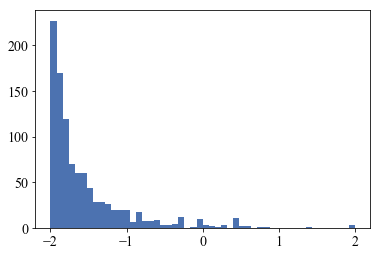

In [162]:
plt.hist(np.log10(ft['period']),bins=50);